In [7]:
import numpy as np;
import scipy.signal as signal
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

#SINC function and transform for different topologies

In [ ]:
def firws(m, f , w , t = None):
    """
    Designs windowed sinc type I linear phase FIR filter.
    Parameters:
        m: filter order.
        f: cutoff frequency/ies (-6 dB;pi rad / sample).
        w: vector of length m + 1 defining window.
        t: 'high' for highpass, 'stop' for bandstop filter. {default low-/bandpass}
    Returns:
        b: numpy.ndarray
            filter coefficients
    """
    f = np.squeeze(f)
    f = f / 2;
    w = np.squeeze(w)
    if (f.ndim == 0): #low pass
        b = fkernel(m, f, w)
    else:
        b = fkernel(m, f[0], w) #band

    if (f.ndim == 0) and (t == 'high'):
        b = fspecinv(b)
    elif (f.size == 2):
        b = b + fspecinv(fkernel(m, f[1], w)) #reject
        if t == None or (t != 'stop'):
            b = fspecinv(b) #bandpass
    return b

In [ ]:
# Compute filter kernel
def fkernel(m, f, w):
    m = np.arange(-m/2, (m/2)+1)
    b = np.zeros((m.shape[0]))
    b[m==0] = 2*np.pi*f # No division by zero
    b[m!=0] = np.sin(2*np.pi*f*m[m!=0]) / m[m!=0] # Sinc
    b = b * w # Windowing
    b = b / np.sum(b) # Normalization to unity gain at DC
    return b

In [ ]:
## Spectral inversion
def fspecinv(b):
    b = -b
    b[int((b.shape[0]-1)/2)] = b[int((b.shape[0]-1)/2)]+1
    return b

#Rules for the order selection based on a Hamming window

In [ ]:
#heuristics for band management
def filter_design(srate, locutoff = 0, hicutoff = 0, revfilt = 0):
    #Constants
    TRANSWIDTHRATIO = 0.25;
    fNyquist = srate/2;

    #The prototipical filter is the low-pass, we design a low pass and transform it
    if hicutoff == 0: #Convert highpass to inverted lowpass
        hicutoff = locutoff
        locutoff = 0
        revfilt = 1 #invert the logic for low-pass to high-pass and for
                    #band-pass to notch
    if locutoff > 0 and hicutoff > 0:
        edgeArray = np.array([locutoff , hicutoff])
    else:
        edgeArray = np.array([hicutoff]);

    #Not negative frequencies and not frequencies above Nyquist
    if np.any(edgeArray<0) or np.any(edgeArray >= fNyquist):
        print('Cutoff frequency out of range')
        return False

    # Max stop-band width
    maxBWArray = edgeArray.copy() # Band-/highpass
    if revfilt == 0: # Band-/lowpass
        maxBWArray[-1] = fNyquist - edgeArray[-1];
    elif len(edgeArray) == 2: # Bandstop
        maxBWArray = np.diff(edgeArray) / 2;
    maxDf = np.min(maxBWArray);

    # Default filter order heuristic
    if revfilt == 1: # Highpass and bandstop
        df = np.min([np.max([maxDf * TRANSWIDTHRATIO, 2]) , maxDf]);
    else: # Lowpass and bandpass
        df = np.min([np.max([edgeArray[0] * TRANSWIDTHRATIO, 2]) , maxDf]);

    print(df)

    filtorder = 3.3 / (df / srate); # Hamming window
    filtorder = np.ceil(filtorder / 2) * 2; # Filter order must be even.

    # Passband edge to cutoff (transition band center; -6 dB)
    dfArray = [[df, [-df, df]] , [-df, [df, -df]]];
    cutoffArray = edgeArray + np.array(dfArray[revfilt][len(edgeArray) - 1]) / 2;
    print('pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): '+str(cutoffArray)+' Hz\n');
    # Window
    winArray = signal.hamming(int(filtorder) + 1);
    # Filter coefficients
    if revfilt == 1:
        filterTypeArray = ['high', 'stop'];
        b = firws(filtorder, cutoffArray / fNyquist, winArray, filterTypeArray[len(edgeArray) - 1]);
    else:
        b = firws(filtorder, cutoffArray / fNyquist, winArray);

    return filtorder, b;

# BODE PLOT

In [9]:
def mfreqz(b,a,order,nyq_rate = 1):

    """
    Plot the impulse response of the filter in the frequency domain

    Parameters:

        b: numerator values of the transfer function (coefficients of the filter)
        a: denominator values of the transfer function (coefficients of the filter)

        order: order of the filter

        nyq_rate = nyquist frequency
    """

    w,h = signal.freqz(b,a);
    h_dB = 20 * np.log10 (abs(h));

    plt.figure();
    plt.subplot(311);
    plt.plot((w/max(w))*nyq_rate,abs(h));
    plt.ylabel('Magnitude');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Frequency response. Order: ' + str(order));
    [xmin, xmax, ymin, ymax] = plt.axis();

    #plt.xlim((40,60))

    plt.grid(True);

    plt.subplot(312);
    plt.plot((w/max(w))*nyq_rate,h_dB);
    plt.ylabel('Magnitude (db)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Frequency response. Order: ' + str(order));
    plt.grid(True)
    plt.grid(True)


    plt.subplot(313);
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)));
    plt.plot((w/max(w))*nyq_rate,h_Phase);
    plt.ylabel('Phase (radians)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Phase response. Order: ' + str(order));
    plt.subplots_adjust(hspace=0.5);
    plt.grid(True)
    plt.show()

###low pass filter 50Hz with order = 265 (for a transition band of 25%) and hamming window

<ipython-input-8-454a39242426>:2: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  b = fkernel(264, 50/1000, signal.hamming(int(264) + 1))


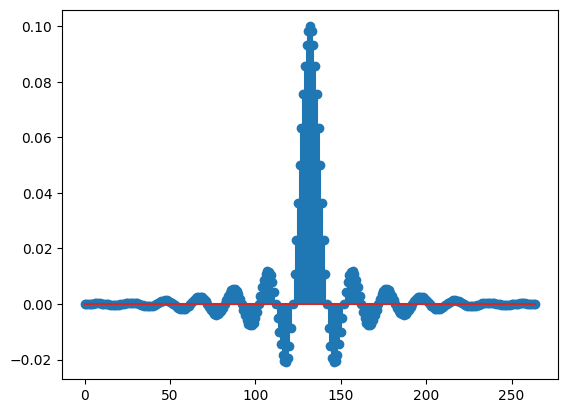

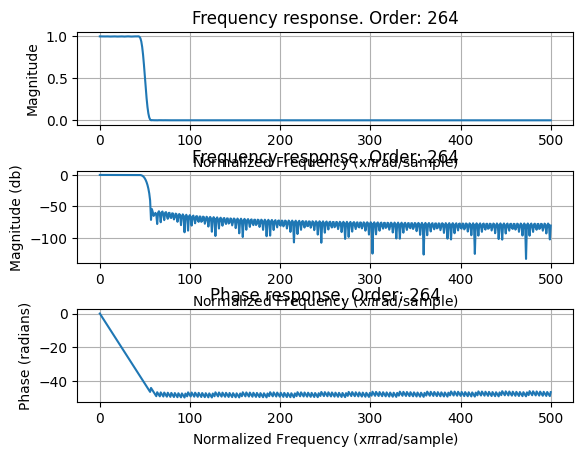

In [ ]:
#fs = 1000
b = fkernel(264, 50/1000, signal.hamming(int(264) + 1))
plt.stem(b)

mfreqz(b,1,264, 500);

In [ ]:
print(b)

[-1.13295899e-04 -6.01155948e-05 -3.86234016e-19  6.18412838e-05
  1.19878401e-04  1.68668572e-04  2.03285798e-04  2.19749206e-04
  2.15420853e-04  1.89339081e-04  1.42451039e-04  7.77089284e-05
 -3.84161260e-19 -8.41091451e-05 -1.66818014e-04 -2.39712228e-04
 -2.94521436e-04 -3.23957318e-04 -3.22555741e-04 -2.87434897e-04
 -2.18877455e-04 -1.20651201e-04  2.00639961e-18  1.32735233e-04
  2.64869625e-04  3.82464057e-04  4.71671668e-04  5.20222940e-04
  5.18901832e-04  4.62849677e-04  3.52534712e-04  1.94244913e-04
 -8.06553854e-19 -2.13167565e-04 -4.24547516e-04 -6.11617483e-04
 -7.52286905e-04 -8.27309800e-04 -8.22618355e-04 -7.31314758e-04
 -5.55072084e-04 -3.04737484e-04  1.13458902e-18  3.31924137e-04
  6.58532415e-04  9.45040677e-04  1.15789184e-03  1.26843232e-03
  1.25637353e-03  1.11264789e-03  8.41302460e-04  4.60148861e-04
 -1.51723238e-18 -4.97537081e-04 -9.83589955e-04 -1.40659772e-03
 -1.71752948e-03 -1.87523860e-03 -1.85139453e-03 -1.63443771e-03
 -1.23206621e-03 -6.71882

### high pass filter 5Hz with order = 265 (for a transition band of 25%) and hamming window

<ipython-input-10-fe2c0c924ee8>:3: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  b = fkernel(264, 5/1000, signal.hamming(int(264) + 1))


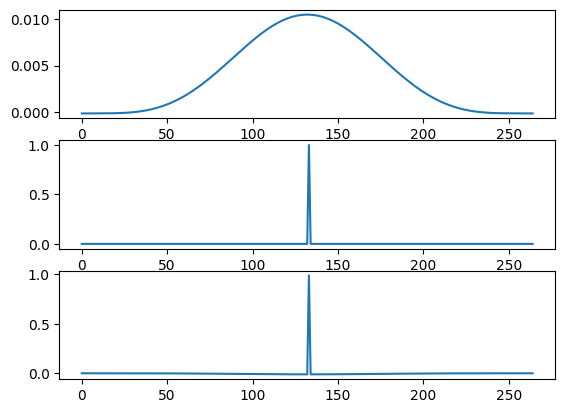

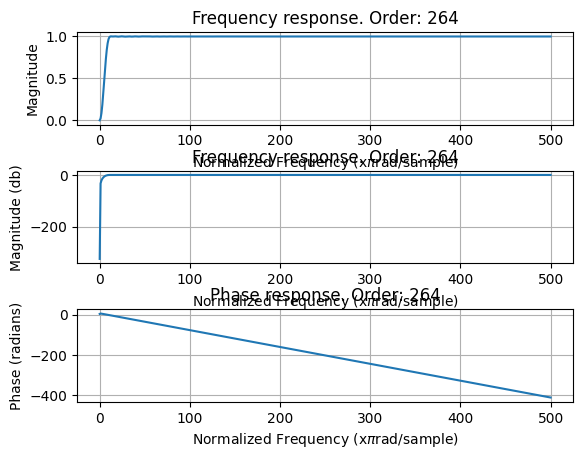

In [ ]:

from scipy import signal

b = fkernel(264, 5/1000, signal.hamming(int(264) + 1))
plt.subplot(3,1,1)
plt.plot(b)

delta = signal.unit_impulse(265,133)
plt.subplot(3,1,2)
plt.plot(delta)

bhpf = delta - b
plt.subplot(3,1,3)
plt.plot(bhpf)

mfreqz(bhpf,1,264, 500);

### high pass filter 5Hz with order = 8 (for a transition band of 25%) and hamming window

<ipython-input-11-92ac5b78a900>:3: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  b = fkernel(8, 5/1000, signal.hamming(8 + 1))


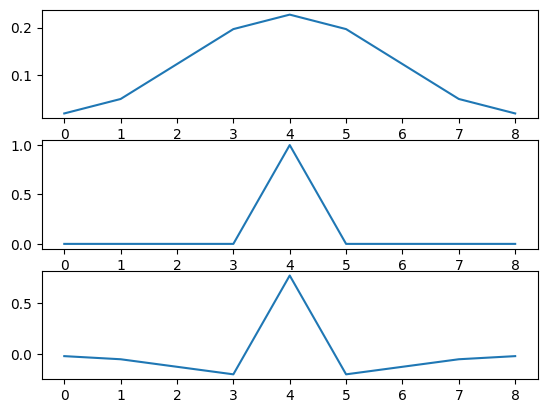

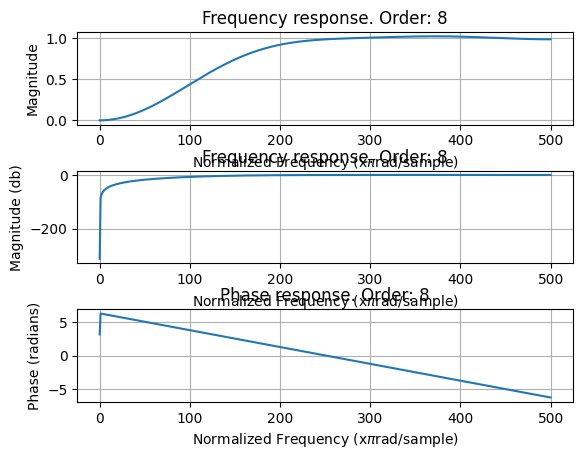

In [ ]:

from scipy import signal

b = fkernel(8, 5/1000, signal.hamming(8 + 1))
plt.subplot(3,1,1)
plt.plot(b)

delta = signal.unit_impulse(9,4)
plt.subplot(3,1,2)
plt.plot(delta)

bhpf = delta - b
plt.subplot(3,1,3)
plt.plot(bhpf)

mfreqz(bhpf,1,8, 500);

## Using the heuristic function (filter_design)

12.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [56.25] Hz



<ipython-input-6-93d00c930b05>:47: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  winArray = signal.hamming(int(filtorder) + 1);


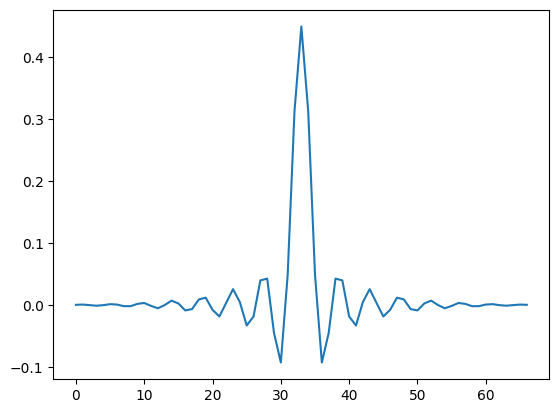

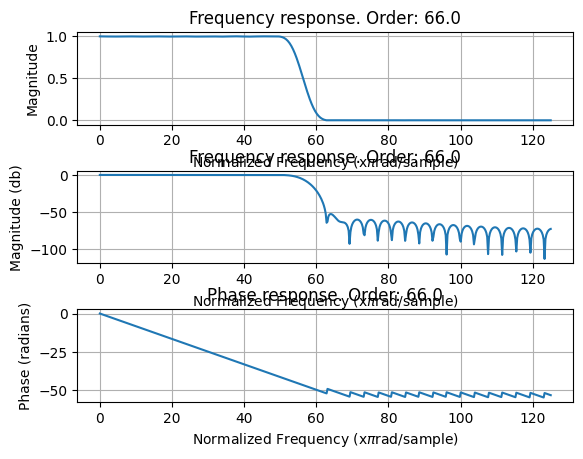

In [ ]:
fs = 250;
#design
order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 50, revfilt = 0);
plt.plot(lowpass)
#plot
mfreqz(lowpass,1,order, fs/2);

2.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [3.] Hz



<ipython-input-6-93d00c930b05>:47: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  winArray = signal.hamming(int(filtorder) + 1);


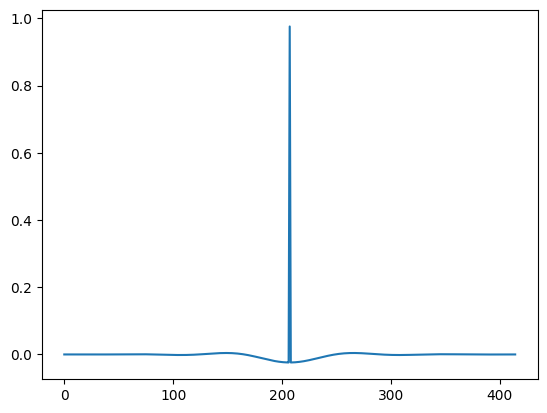

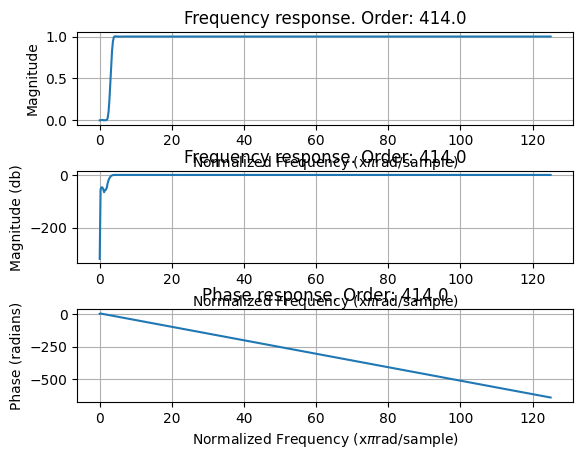

In [ ]:
order, highpass = filter_design(fs, locutoff = 4, hicutoff = 0, revfilt = 1);
plt.plot(highpass)
#plot
mfreqz(highpass,1,order, fs/2);

2.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [ 3. 51.] Hz



<ipython-input-6-93d00c930b05>:47: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  winArray = signal.hamming(int(filtorder) + 1);


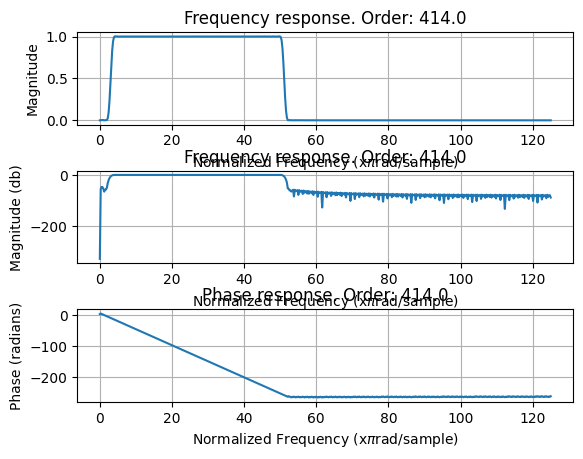

In [ ]:
order, bandpass = filter_design(fs, locutoff = 4, hicutoff = 50, revfilt = 0);
#plot
mfreqz(bandpass,1,order, fs/2);

2.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [51.25 68.75] Hz



<ipython-input-6-93d00c930b05>:47: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  winArray = signal.hamming(int(filtorder) + 1);


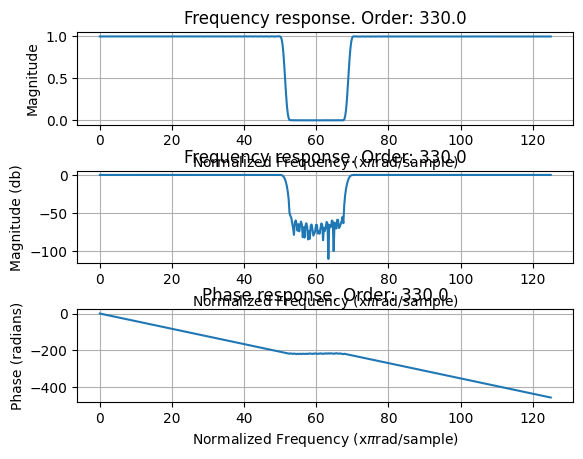

In [ ]:
order, notch = filter_design(fs, locutoff = 50, hicutoff = 70, revfilt = 1);
#plot
mfreqz(notch,1,order, fs/2);

Los campos cargados son: dict_keys(['__header__', '__version__', '__globals__', 'data', 'fs'])


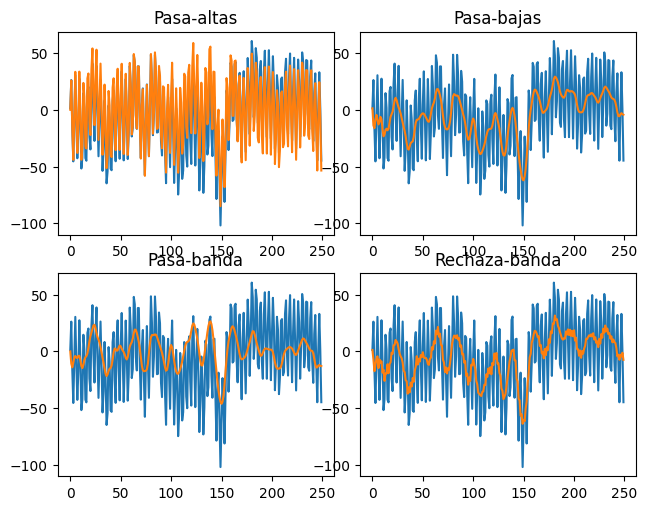

In [ ]:
#%%load signal and apply filter
import scipy.io as sio;
#carga de los datos
mat_contents = sio.loadmat('/content/drive/Shareddrives/biosenales_sistemas/filtrado/senal_anestesia.mat')
#los datos se cargan como un diccionario, se puede evaluar los campos que contiene
print("Los campos cargados son: " + str(mat_contents.keys()));
#la senal esta en el campo data
senal_org = mat_contents['data'];
senal_org = senal_org[0,:];

senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, senal_org);
senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_org);
senal_filtrada_pasabanda = signal.filtfilt(bandpass, 1, senal_org);
senal_filtrada_rechazabanda = signal.filtfilt(notch, 1, senal_org);

plt.subplot(2,2,1);
plt.tight_layout()
plt.plot(senal_org[0:250]);
plt.plot(senal_filtrada_pasaaltas[0:250]);
plt.title('Pasa-altas');
plt.subplot(2,2,2);
plt.plot(senal_org[0:250]);
plt.plot(senal_filtrada_pasabajas[0:250]);
plt.title('Pasa-bajas');
plt.subplot(2,2,3);
plt.plot(senal_org[0:250]);
plt.plot(senal_filtrada_pasabanda[0:250]);
plt.title('Pasa-banda');
plt.subplot(2,2,4);
plt.plot(senal_org[0:250]);
plt.plot(senal_filtrada_rechazabanda[0:250]);
plt.title('Rechaza-banda');

plt.show();

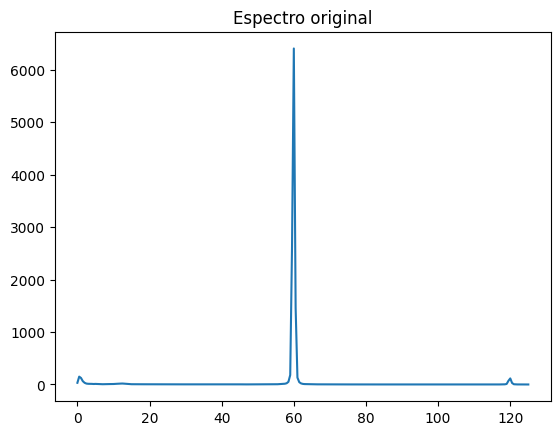

In [ ]:
import scipy.signal as pds

f, Pxx = pds.welch(senal_org, fs, 'hann', fs*2, fs)
plt.title('Espectro original');
plt.plot(f, Pxx);
plt.show()

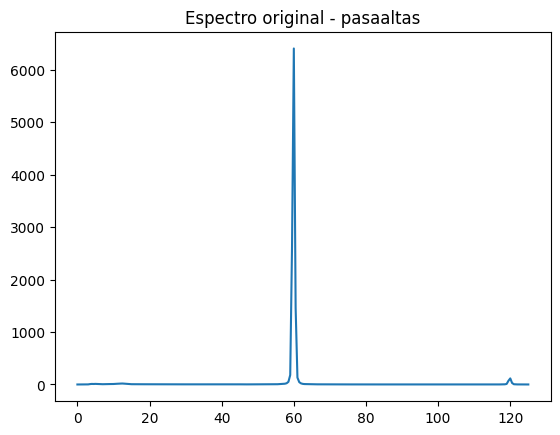

In [ ]:
f, Pxx = pds.welch(senal_filtrada_pasaaltas, fs, 'hann', fs*2, fs)
plt.title('Espectro original - pasaaltas');
plt.plot(f, Pxx);
plt.show()

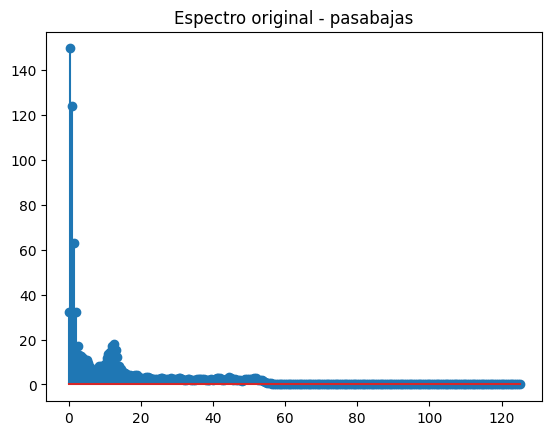

In [ ]:
f, Pxx = pds.welch(senal_filtrada_pasabajas, fs, 'hann', fs*2, fs)
plt.title('Espectro original - pasabajas');
plt.stem(f, Pxx);
plt.show()

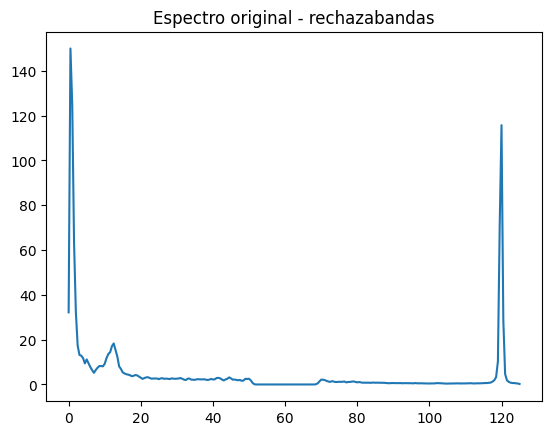

In [ ]:
f, Pxx = pds.welch(senal_filtrada_rechazabanda, fs, 'hann', fs*2, fs)
plt.title('Espectro original - rechazabandas');
plt.plot(f, Pxx);
plt.show()

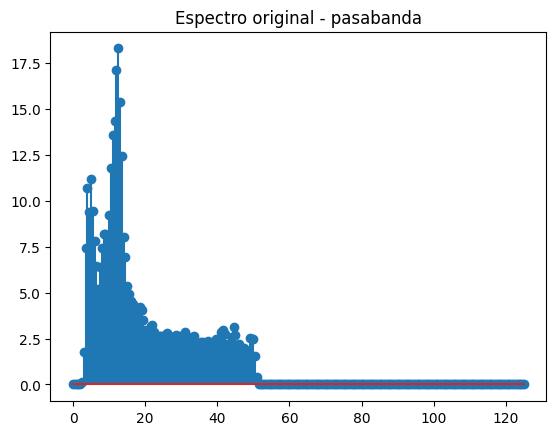

In [ ]:
f, Pxx = pds.welch(senal_filtrada_pasabanda, fs, 'hann', fs*2, fs)
plt.title('Espectro original - pasabanda');
plt.stem(f, Pxx);
plt.show()

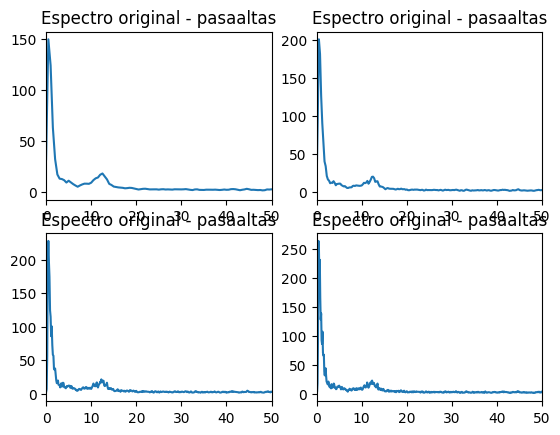

In [ ]:
f, Pxx = pds.welch(senal_filtrada_pasabajas, fs, 'hann', fs*2, fs)
plt.subplot(2,2,1);
plt.title('Espectro original - pasaaltas');
plt.xlim([0,50]);
plt.plot(f, Pxx);

f, Pxx = pds.welch(senal_filtrada_pasabajas, fs, 'hann', fs*4, fs*2)
plt.subplot(2,2,2);
plt.title('Espectro original - pasaaltas');
plt.xlim([0,50]);
plt.plot(f, Pxx);

f, Pxx = pds.welch(senal_filtrada_pasabajas, fs, 'hann', fs*8, fs*4)
plt.subplot(2,2,3);
plt.title('Espectro original - pasaaltas');
plt.xlim([0,50]);
plt.plot(f, Pxx);

f, Pxx = pds.welch(senal_filtrada_pasabajas, fs, 'hann', fs*10, fs*5)
plt.subplot(2,2,4);
plt.title('Espectro original - pasaaltas');
plt.plot(f, Pxx);
plt.xlim([0,50]);
plt.show()

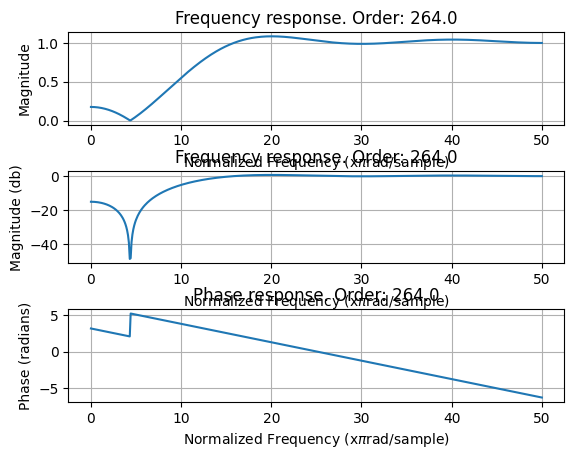

[-0.04774188 -0.10299731 -0.15449597 -0.19096752  0.81654604 -0.19096752
 -0.15449597 -0.10299731 -0.04774188]


In [ ]:
## Design a FIR filter

#scipy.signal.firwin(numtaps, cutoff, *, width=None, window='hamming', pass_zero=True, scale=True, nyq=<object object>, fs=None)[source]


N = 9 # filter order

fs = 100

# compute the filter coefficients
b = signal.firwin(N, 10/(fs/2), window = 'boxcar', pass_zero='highpass')

mfreqz(b,1,order, fs/2);

print(b)

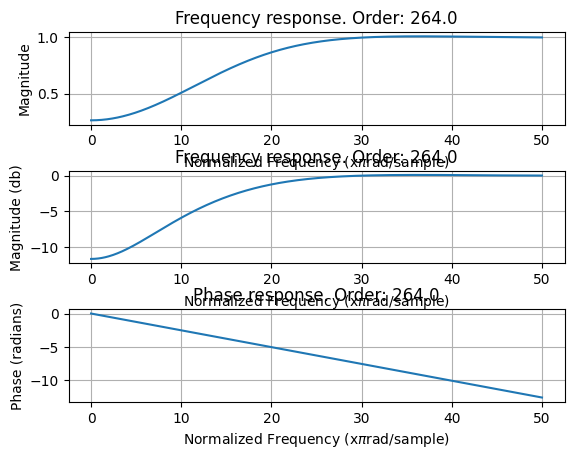

In [ ]:
## Design a FIR filter

#scipy.signal.firwin(numtaps, cutoff, *, width=None, window='hamming', pass_zero=True, scale=True, nyq=<object object>, fs=None)[source]


N = 9 # filter order

fs = 100

# compute the filter coefficients
b = signal.firwin(N, 10/(fs/2), pass_zero='highpass')

mfreqz(b,1,order, fs/2);

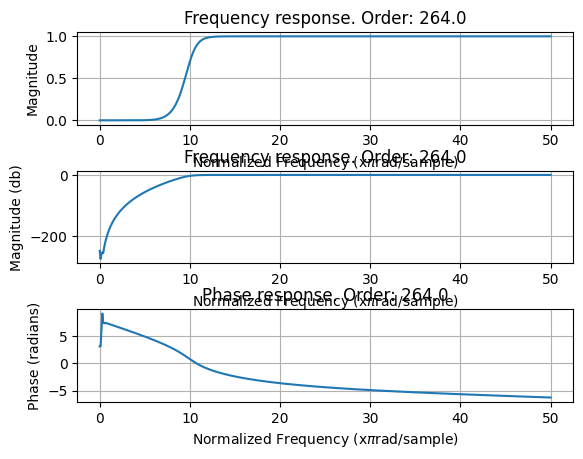

[  0.15736915  -1.41632233   5.6652893  -13.21900837  19.82851255
 -19.82851255  13.21900837  -5.6652893    1.41632233  -0.15736915]
[  1.          -5.38622099  13.37855009 -19.96168225  19.62398217
 -13.13702764   5.97321467  -1.77517968   0.31238085  -0.02476505]


In [ ]:
## Design a iir filter using scipy

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html
#scipy.signal.iirfilter(N, Wn, rp=None, rs=None, btype='band', analog=False, ftype='butter', output='ba', fs=None)

N = 9 # filter order

fs = 100

# compute the filter coefficients
b,a = signal.iirfilter(N, 10/(fs/2), btype='highpass', ftype='butter')

mfreqz(b,a,order, fs/2);

print(b)
print(a)

# __________________________________________________________________________________________________

# PROYECTO

C:\Users\malej\AppData\Local\Temp\ipykernel_17648\1227699950.py:17: RuntimeWarning: divide by zero encountered in log10
  h_dB = 20 * np.log10 (abs(h));


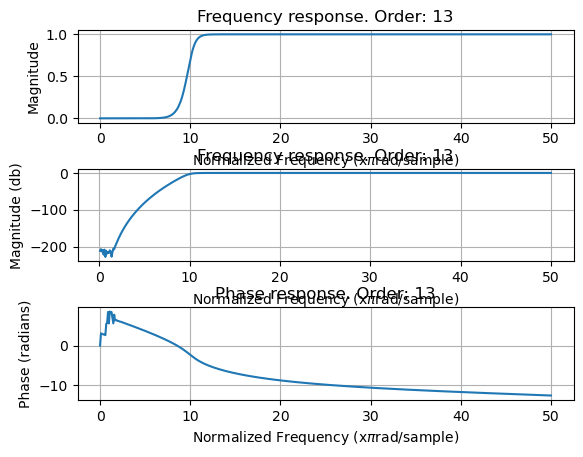

[ 6.96292722e-02 -9.05180538e-01  5.43108323e+00 -1.99139718e+01
  4.97849296e+01 -8.96128733e+01  1.19483831e+02 -1.19483831e+02
  8.96128733e+01 -4.97849296e+01  1.99139718e+01 -5.43108323e+00
  9.05180538e-01 -6.96292722e-02]
[ 1.00000000e+00 -7.79044125e+00  2.87136284e+01 -6.60687322e+01
  1.05615860e+02 -1.23620165e+02  1.08821382e+02 -7.28488855e+01
  3.70449861e+01 -1.41196051e+01  3.91748615e+00 -7.48693011e-01
  8.82842300e-02 -4.84823554e-03]


In [37]:
## DISEÑANDO FILTRO PROYECTO

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html
#scipy.signal.iirfilter(N, Wn, rp=None, rs=None, btype='band', analog=False, ftype='butter', output='ba', fs=None)

N = 13# filter order

fs = 100

# compute the filter coefficients
b_P,a_P = signal.iirfilter(N, 10/(fs/2), btype='highpass', ftype='butter')

mfreqz(b_P,a_P,N, fs/2);

print(b_P)
print(a_P)

In [43]:
b_nuevo= np.around(b_P, decimals=5)
a_nuevo= np.around(a_P, decimals=5)
print(b_nuevo)
print(a_nuevo)

[ 6.9630000e-02 -9.0518000e-01  5.4310800e+00 -1.9913970e+01
  4.9784930e+01 -8.9612870e+01  1.1948383e+02 -1.1948383e+02
  8.9612870e+01 -4.9784930e+01  1.9913970e+01 -5.4310800e+00
  9.0518000e-01 -6.9630000e-02]
[ 1.0000000e+00 -7.7904400e+00  2.8713630e+01 -6.6068730e+01
  1.0561586e+02 -1.2362017e+02  1.0882138e+02 -7.2848890e+01
  3.7044990e+01 -1.4119610e+01  3.9174900e+00 -7.4869000e-01
  8.8280000e-02 -4.8500000e-03]


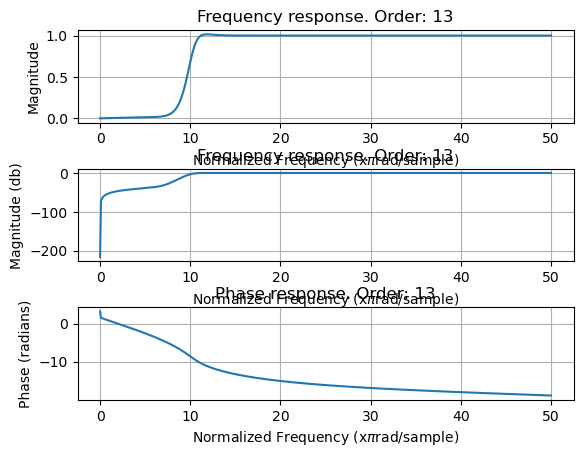

In [44]:
mfreqz(b_nuevo,a_nuevo,N, fs/2);

# _________________________________________________________________________________________________

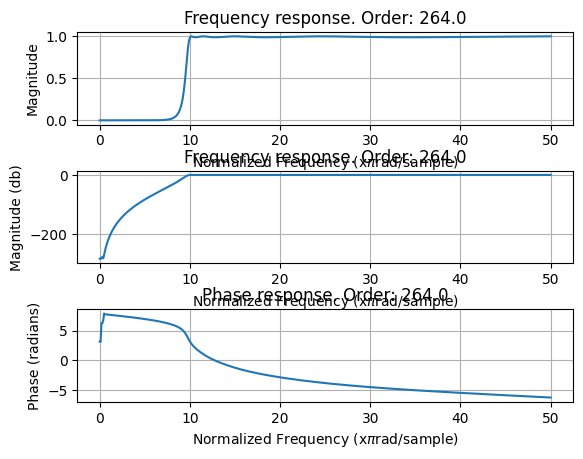

[  0.0931175   -0.83805751   3.35223005  -7.82187011  11.73280517
 -11.73280517   7.82187011  -3.35223005   0.83805751  -0.0931175 ]
[ 1.00000000e+00 -4.38813808e+00  9.38325258e+00 -1.22849371e+01
  1.07762616e+01 -6.46854134e+00  2.63623032e+00 -6.65967283e-01
  7.99289745e-02  7.09656193e-03]


In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html
#scipy.signal.iirfilter(N, Wn, rp=None, rs=None, btype='band', analog=False, ftype='butter', output='ba', fs=None)

N = 9 # filter order

fs = 100

# compute the filter coefficients
b,a = signal.iirfilter(N, 10/(fs/2), btype='highpass', ftype='cheby1',rp=0.1,rs=10)

mfreqz(b,a,order, fs/2);

print(b)
print(a)

<ipython-input-7-becb92e6be07>:17: RuntimeWarning: divide by zero encountered in log10
  h_dB = 20 * np.log10 (abs(h));


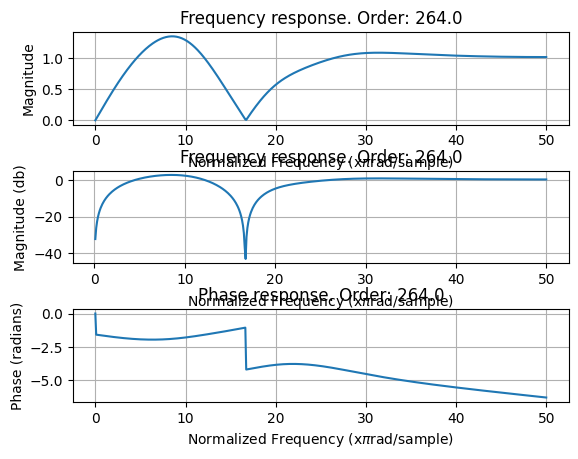

[  0.0931175   -0.83805751   3.35223005  -7.82187011  11.73280517
 -11.73280517   7.82187011  -3.35223005   0.83805751  -0.0931175 ]
[ 1.00000000e+00 -4.38813808e+00  9.38325258e+00 -1.22849371e+01
  1.07762616e+01 -6.46854134e+00  2.63623032e+00 -6.65967283e-01
  7.99289745e-02  7.09656193e-03]


In [ ]:
b_round = np.round(b, decimals=0, out=None)
a_round = np.round(a, decimals=0, out=None)

mfreqz(b_round,a_round,order, fs/2);

print(b)
print(a)

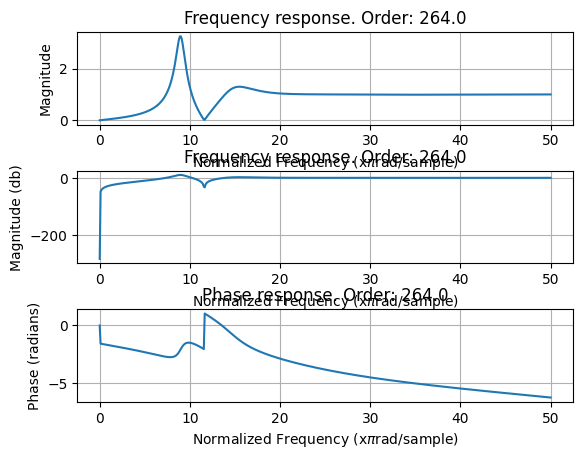

[  0.09  -0.84   3.35  -7.82  11.73 -11.73   7.82  -3.35   0.84  -0.09]
[ 1.000e+00 -4.390e+00  9.380e+00 -1.228e+01  1.078e+01 -6.470e+00
  2.640e+00 -6.700e-01  8.000e-02  1.000e-02]


In [ ]:
b_round = np.round(b, decimals=2, out=None)
a_round = np.round(a, decimals=2, out=None)

mfreqz(b_round,a_round,order, fs/2);

print(b_round)
print(a_round)

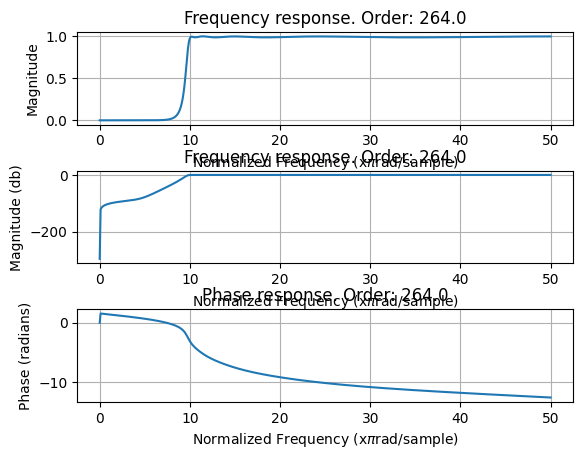

[  0.09312  -0.83806   3.35223  -7.82187  11.73281 -11.73281   7.82187
  -3.35223   0.83806  -0.09312]
[ 1.000000e+00 -4.388140e+00  9.383250e+00 -1.228494e+01  1.077626e+01
 -6.468540e+00  2.636230e+00 -6.659700e-01  7.993000e-02  7.100000e-03]


In [ ]:
#https://www.arduino.cc/reference/en/language/variables/data-types/float/

#The float data type has only 6-7 decimal digits of precision.
#That means the total number of digits, not the number to the right of the decimal point.
#Unlike other platforms, where you can get more precision by using a double (e.g. up to 15 digits), on the Arduino, double is the same size as float.
b_round = np.round(b, decimals=5, out=None)
a_round = np.round(a, decimals=5, out=None)

mfreqz(b_round,a_round,order, fs/2);

print(b_round)
print(a_round)

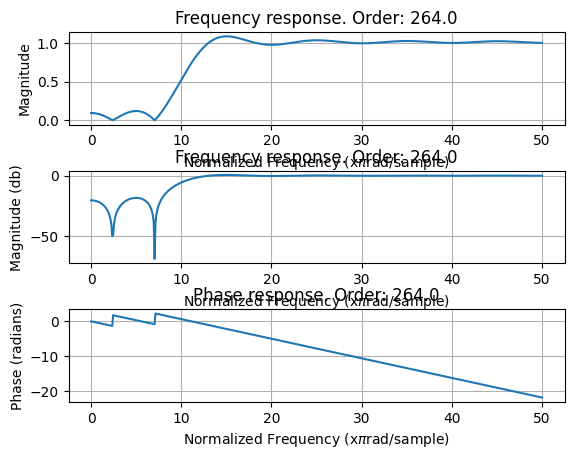

[ 2.10047180e-02  3.82346411e-02  4.36967327e-02  3.15070770e-02
  3.15095004e-17 -4.72606155e-02 -1.01959043e-01 -1.52938564e-01
 -1.89042462e-01  8.08314815e-01 -1.89042462e-01 -1.52938564e-01
 -1.01959043e-01 -4.72606155e-02  3.15095004e-17  3.15070770e-02
  4.36967327e-02  3.82346411e-02  2.10047180e-02]


In [ ]:
## Design a FIR filter

#scipy.signal.firwin(numtaps, cutoff, *, width=None, window='hamming', pass_zero=True, scale=True, nyq=<object object>, fs=None)[source]


N = 19 # filter order

fs = 100

# compute the filter coefficients
b = signal.firwin(N, 10/(fs/2), window = 'boxcar', pass_zero='highpass')

mfreqz(b,1,order, fs/2);

print(b)